In [ ]:
import os, json, time, pickle, wandb
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.ensemble import RandomForestRegressor
from lib.items import Item
from lib.utils import Tester, make_pricer_predictor, llm_pricer_predictor, messages_for
from lib.utils import write_jsonl, llm_finetuned_pricer_predictor, finetuned_messages_for
from lib.utils import open_source_pricer_predictor
from pathlib import Path
from openai import OpenAI
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM
from datasets import load_dataset
from datetime import datetime
%matplotlib inline

# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
%cd ../..
project_folder = Path("AI/deals_agents")
preprocessed_data = project_folder/"output"/"preprocessed_data"

/home/hien/Work


In [3]:
# loading the pkl files

with open(preprocessed_data/'train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open(preprocessed_data/'test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

# Baseline Models

## Word2Vec

In [4]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [5]:
np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [6]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

## Random Forest

In [7]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


1: Guess: $23.17 Truth: $21.99 Error: $1.18 SLE: 0.00 Item: The Petting Zoo Bald Eagle Stuffed Animal, Gifts for Kids, Wild Onez Zoo Animals, Bald Eagle Plush Toy 12 inches
2: Guess: $68.71 Truth: $99.99 Error: $31.28 SLE: 0.14 Item: Black Tilting Wall Mount Bracket for Vizio VX42L LCD 42 inch HDTV TV
3: Guess: $94.34 Truth: $199.00 Error: $104.66 SLE: 0.55 Item: Xantech Ensemble Universal IR Kit EN85K
4: Guess: $18.11 Truth: $15.99 Error: $2.12 SLE: 0.01 Item: Teenager Birthday Party Decoration 13th Birthday Party Decorations for Girls, Omg Ur A Teenager Birthday Banner Rose Gold 13 Birthday Balloons Confetti Balloons for 13th Birthday Girls Her Daughter
5: Guess: $194.39 Truth: $229.99 Error: $35.60 SLE: 0.03 Item: Kodak PIXPRO Astro Zoom AZ421 16MP Digital Camera (White) Bundle with 32GB SD Card, Camera Case and Accessory Bundle (4 Items)
6: Guess: $77.08 Truth: $24.44 Error: $52.64 SLE: 1.26 Item: Blessing Alto Saxophone Case (MPC7CTR)
7: Guess: $51.74 Truth: $9.99 Error: $41.75 SL

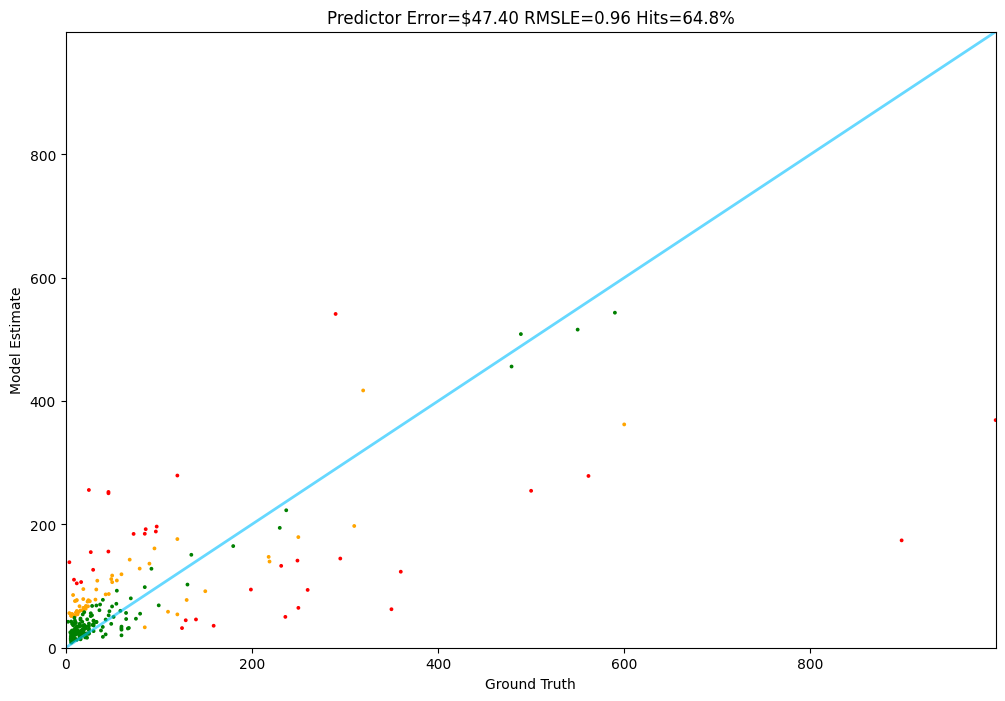

In [8]:
predictor = make_pricer_predictor(document_vector, rf_model)
Tester.test(predictor, test)

# OpenAI

## Base Model

In [7]:
test[0].price

21.99

In [8]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nThe Petting Zoo Bald Eagle Stuffed Animal, Gifts for Kids, Wild Onez Zoo Animals, Bald Eagle Plush Toy 12 inches\nBeing eco-friendly and long lasting like this Bald Eagle are one of many ways The Petting Zoo is stepping up in the plush toy world. Introduce and kindle the fun of learning about the animal kingdom. Let the imagination flow, infinite adventures are ready to be had with your loved one and their favorite buddy. Welcome to the world of Wild Onez, our unique collection of realistic stuffed animals that are designed to bring the experience of wildlife to your child, providing endless hours of imaginative play, and maybe even a treasured companion for years to come. Every one of our Wild Onez plush toys are made from recycled water bottles. Each time you recycle'},
 {'role': 'assistant', 'content': 'Price is $'}]

1: Guess: $15.00 Truth: $21.99 Error: $6.99 SLE: 0.13 Item: The Petting Zoo Bald Eagle Stuffed Anima...
2: Guess: $35.99 Truth: $99.99 Error: $64.00 SLE: 1.01 Item: Black Tilting Wall Mount Bracket for Viz...
3: Guess: $250.00 Truth: $199.00 Error: $51.00 SLE: 0.05 Item: Xantech Ensemble Universal IR Kit EN85K
4: Guess: $16.99 Truth: $15.99 Error: $1.00 SLE: 0.00 Item: Teenager Birthday Party Decoration 13th ...
5: Guess: $250.00 Truth: $229.99 Error: $20.01 SLE: 0.01 Item: Kodak PIXPRO Astro Zoom AZ421 16MP Digit...
6: Guess: $50.00 Truth: $24.44 Error: $25.56 SLE: 0.48 Item: Blessing Alto Saxophone Case (MPC7CTR)
7: Guess: $15.99 Truth: $9.99 Error: $6.00 SLE: 0.19 Item: 2PCS Household Basics Battery Chargers f...
8: Guess: $15.99 Truth: $16.99 Error: $1.00 SLE: 0.00 Item: SpyShop Oversize Water Bubble Ball Toy G...
9: Guess: $12.99 Truth: $75.50 Error: $62.51 SLE: 2.89 Item: Funko POP Movies: Breakfast Club - Richa...
10: Guess: $1,000.00 Truth: $999.00 Error: $1.00 SLE: 0.00 Item: 

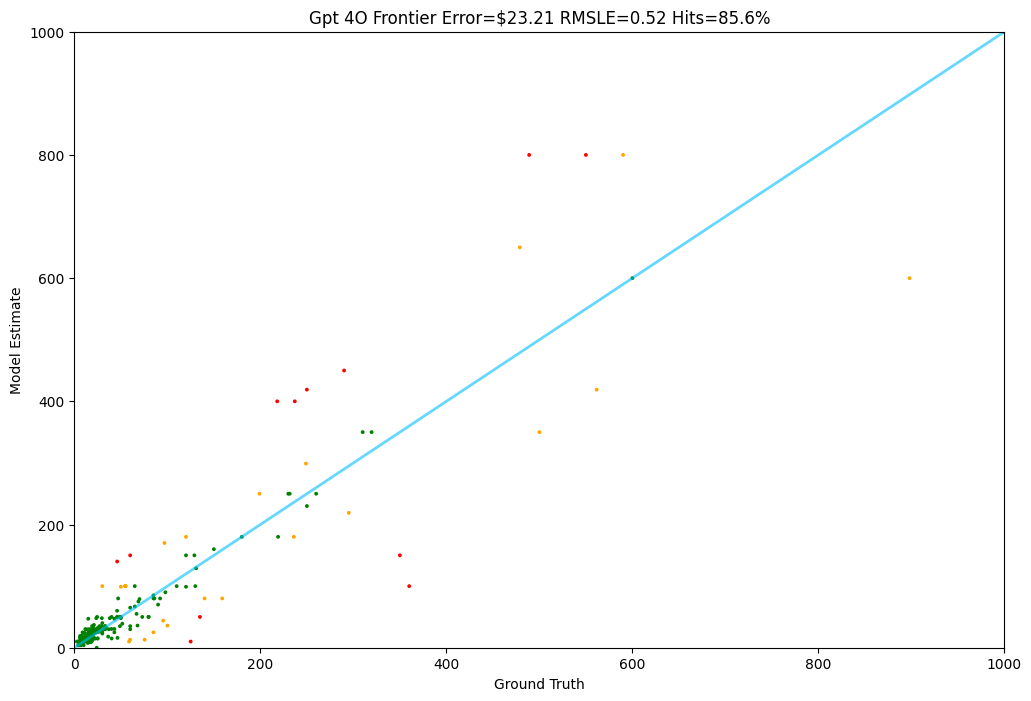

In [ ]:
predictor = llm_pricer_predictor()  # This is now a function: item -> price
Tester.test(predictor, test)        # Pass predictor and your dataset

## Fine-tuning Frontier OpenAI Model

### Data Preparation

In [9]:
finetuned_messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDisney Cars 2 Party Temporary Tattoos\nDisney Cars 2 Party Temporary Tattoos. One package of Disney Cars 2 Party Temporary Tattoos. Each package has 2 sheets of temporary tattoos for a total of 12. Great for all your guests! Disney Cars 2 Party Temporary Tattoos One package of Disney Cars 2 Party Temporary Tattoos Each package has 2 sheets of temporary tattoos for a total of 12 Color Multi-colored, Brand Hallmark, Size One Size, Water Resistance Level Water Resistant, Pieces 12, Is Discontinued No, Dimensions 7.4 x 4 x 0.3 inches; 0.8 Ounces, Manufacturer recommended age 12 months and up, model number Department PARTY SUPPLIES, UPC Manufacturer Hallmark Party Express'},
 {'role': 'assistant', 'content': 'Price is $2.49'}]

In [10]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

In [11]:
write_jsonl(fine_tune_train, preprocessed_data/"fine_tune_train.jsonl")
write_jsonl(fine_tune_validation, preprocessed_data/"fine_tune_validation.jsonl")

In [12]:
client = OpenAI()

with open(preprocessed_data/"fine_tune_train.jsonl", "rb") as f:
    train_file = client.files.create(file=f, purpose="fine-tune")

with open(preprocessed_data/"fine_tune_validation.jsonl", "rb") as f:
    validation_file = client.files.create(file=f, purpose="fine-tune")

### Fine-tuning

In [ ]:
with open(preprocessed_data/'fine_tune_train.jsonl') as f:
    for i, line in enumerate(f):
        print(json.loads(line))
        if i > 10:
            break

{'messages': [{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'How much does this cost?\n\nDisney Cars 2 Party Temporary Tattoos\nDisney Cars 2 Party Temporary Tattoos. One package of Disney Cars 2 Party Temporary Tattoos. Each package has 2 sheets of temporary tattoos for a total of 12. Great for all your guests! Disney Cars 2 Party Temporary Tattoos One package of Disney Cars 2 Party Temporary Tattoos Each package has 2 sheets of temporary tattoos for a total of 12 Color Multi-colored, Brand Hallmark, Size One Size, Water Resistance Level Water Resistant, Pieces 12, Is Discontinued No, Dimensions 7.4 x 4 x 0.3 inches; 0.8 Ounces, Manufacturer recommended age 12 months and up, model number Department PARTY SUPPLIES, UPC Manufacturer Hallmark Party Express'}, {'role': 'assistant', 'content': 'Price is $2.49'}]}
{'messages': [{'role': 'system', 'content': 'You estimate prices of items. Reply only with 

In [ ]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [ ]:
train_file.id

'file-5jrTszvpYYjWdUgfAe7B4T'

In [ ]:
client.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-2024-08-06",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-eO4IUsEAqz6Lg5gvrNg2UhH8', created_at=1751585337, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-j1ixePjQPh50flCPzA4mzXwD', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-5jrTszvpYYjWdUgfAe7B4T', validation_file='file-QvRR4Y9ZAYCT3p5UR5mmEL', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-eO4IUsEAqz6Lg5gvrNg2UhH8'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='pricer', u

In [ ]:
client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-eO4IUsEAqz6Lg5gvrNg2UhH8', created_at=1751585337, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-j1ixePjQPh50flCPzA4mzXwD', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-5jrTszvpYYjWdUgfAe7B4T', validation_file='file-QvRR4Y9ZAYCT3p5UR5mmEL', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-eO4IUsEAqz6Lg5gvrNg2UhH8'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)

In [ ]:
job_id = client.fine_tuning.jobs.list(limit=1).data[0].id
job_id

'ftjob-eO4IUsEAqz6Lg5gvrNg2UhH8'

In [ ]:
client.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-eO4IUsEAqz6Lg5gvrNg2UhH8', created_at=1751585337, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-j1ixePjQPh50flCPzA4mzXwD', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-5jrTszvpYYjWdUgfAe7B4T', validation_file='file-QvRR4Y9ZAYCT3p5UR5mmEL', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-eO4IUsEAqz6Lg5gvrNg2UhH8'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='pricer', u

In [ ]:
client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-u5v904frsXW0pm6P1nSJDnKF', created_at=1751585337, level='info', message='Validating training file: file-5jrTszvpYYjWdUgfAe7B4T and validation file: file-QvRR4Y9ZAYCT3p5UR5mmEL', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-DoEqDQYvDXFmoK8NzUFUAcTw', created_at=1751585337, level='info', message='Created fine-tuning job: ftjob-eO4IUsEAqz6Lg5gvrNg2UhH8', object='fine_tuning.job.event', data={}, type='message')]

### Testing

In [ ]:
# job_id = 'ftjob-eO4IUsEAqz6Lg5gvrNg2UhH8' # reuse the previous fine-tuned model
fine_tuned_model_name = client.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [ ]:
# to check if training is still running

while True:
    job = client.fine_tuning.jobs.retrieve(job_id)
    print("Status:", job.status)
    if job.status == 'succeeded':
        print("Fine-tuned model:", job.fine_tuned_model)
        fine_tuned_model_name = job.fine_tuned_model
        break
    elif job.status == 'failed':
        print("Fine-tuning failed.")
        fine_tuned_model_name = None
        break
    time.sleep(10)  # Wait 10 seconds before checking again#

Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: validating_files
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: ru

1: Guess: $14.99 Truth: $21.99 Error: $7.00 SLE: 0.13 Item: The Petting Zoo Bald Eagle Stuffed Anima...
2: Guess: $24.99 Truth: $99.99 Error: $75.00 SLE: 1.84 Item: Black Tilting Wall Mount Bracket for Viz...
3: Guess: $66.47 Truth: $199.00 Error: $132.53 SLE: 1.18 Item: Xantech Ensemble Universal IR Kit EN85K
4: Guess: $5.99 Truth: $15.99 Error: $10.00 SLE: 0.79 Item: Teenager Birthday Party Decoration 13th ...
5: Guess: $239.00 Truth: $229.99 Error: $9.01 SLE: 0.00 Item: Kodak PIXPRO Astro Zoom AZ421 16MP Digit...
6: Guess: $5.99 Truth: $24.44 Error: $18.45 SLE: 1.67 Item: Blessing Alto Saxophone Case (MPC7CTR)
7: Guess: $11.99 Truth: $9.99 Error: $2.00 SLE: 0.03 Item: 2PCS Household Basics Battery Chargers f...
8: Guess: $3.99 Truth: $16.99 Error: $13.00 SLE: 1.64 Item: SpyShop Oversize Water Bubble Ball Toy G...
9: Guess: $11.99 Truth: $75.50 Error: $63.51 SLE: 3.14 Item: Funko POP Movies: Breakfast Club - Richa...
10: Guess: $889.99 Truth: $999.00 Error: $109.01 SLE: 0.01 Item: Ni

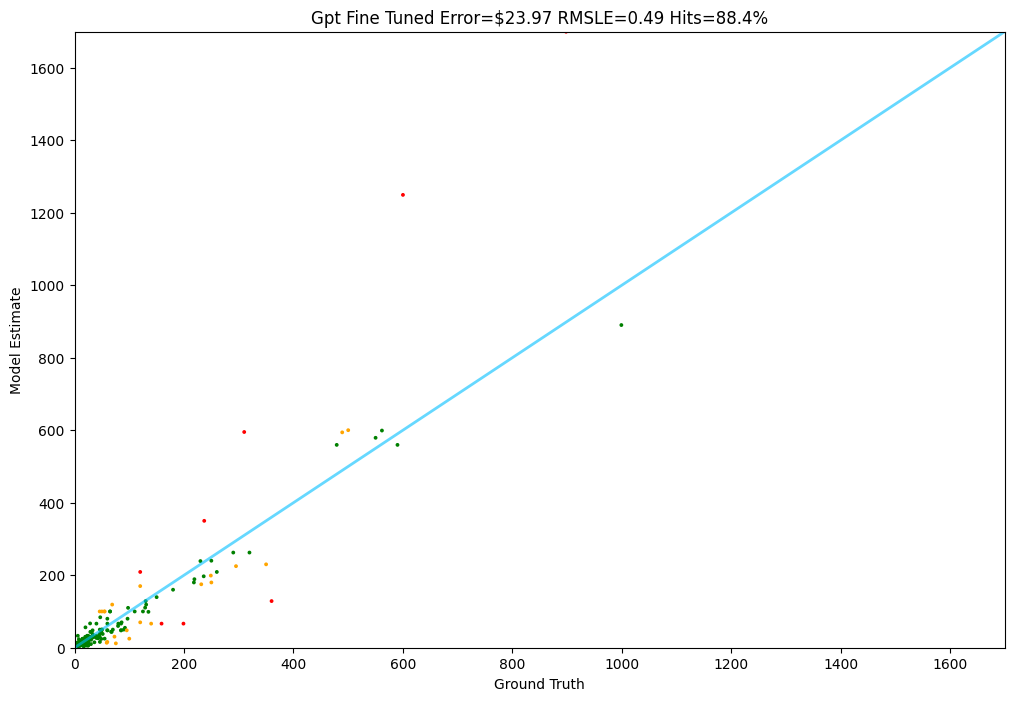

In [ ]:
predictor = llm_finetuned_pricer_predictor(fine_tuned_model_name)
Tester.test(predictor, test)

# Meta LLAMA

## Base Model

In [2]:
# Tokenizers

LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"

# Constants

BASE_MODEL = LLAMA_3_1
HF_USER = "hiennguyen231191"
DATASET_NAME = f"{HF_USER}/lite-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

In [3]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [4]:
train[0]

{'text': 'How much does this cost to the nearest dollar?\n\nDisney Cars 2 Party Temporary Tattoos\nDisney Cars 2 Party Temporary Tattoos. One package of Disney Cars 2 Party Temporary Tattoos. Each package has 2 sheets of temporary tattoos for a total of 12. Great for all your guests! Disney Cars 2 Party Temporary Tattoos One package of Disney Cars 2 Party Temporary Tattoos Each package has 2 sheets of temporary tattoos for a total of 12 Color Multi-colored, Brand Hallmark, Size One Size, Water Resistance Level Water Resistant, Pieces 12, Is Discontinued No, Dimensions 7.4 x 4 x 0.3 inches; 0.8 Ounces, Manufacturer recommended age 12 months and up, model number Department PARTY SUPPLIES, UPC Manufacturer Hallmark Party Express\n\nPrice is $2.00',
 'price': 2.49}

In [5]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\nThe Petting Zoo Bald Eagle Stuffed Animal, Gifts for Kids, Wild Onez Zoo Animals, Bald Eagle Plush Toy 12 inches\nBeing eco-friendly and long lasting like this Bald Eagle are one of many ways The Petting Zoo is stepping up in the plush toy world. Introduce and kindle the fun of learning about the animal kingdom. Let the imagination flow, infinite adventures are ready to be had with your loved one and their favorite buddy. Welcome to the world of Wild Onez, our unique collection of realistic stuffed animals that are designed to bring the experience of wildlife to your child, providing endless hours of imaginative play, and maybe even a treasured companion for years to come. Every one of our Wild Onez plush toys are made from recycled water bottles. Each time you recycle\n\nPrice is $',
 'price': 21.99}

### Prepare the Base Llama Model with 4 Bit Quantization

In [4]:
## pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5.6 GB


1: Guess: $7.99 Truth: $21.99 Error: $14.00 SLE: 0.88 Item: The Petting Zoo Bald Eagle Stuffed Anima...
2: Guess: $25.00 Truth: $99.99 Error: $74.99 SLE: 1.84 Item: Black Tilting Wall Mount Bracket for Viz...
3: Guess: $299.00 Truth: $199.00 Error: $100.00 SLE: 0.16 Item: Xantech Ensemble Universal IR Kit EN85K
...
4: Guess: $25.00 Truth: $15.99 Error: $9.01 SLE: 0.18 Item: Teenager Birthday Party Decoration 13th ...
5: Guess: $299.00 Truth: $229.99 Error: $69.01 SLE: 0.07 Item: Kodak PIXPRO Astro Zoom AZ421 16MP Digit...
6: Guess: $25.00 Truth: $24.44 Error: $0.56 SLE: 0.00 Item: Blessing Alto Saxophone Case
Blessing Tr...
7: Guess: $7.99 Truth: $9.99 Error: $2.00 SLE: 0.04 Item: 2PCS Household Basics Battery Chargers f...
8: Guess: $25.99 Truth: $16.99 Error: $9.00 SLE: 0.16 Item: SpyShop Oversize Water Bubble Ball Toy G...
9: Guess: $25.00 Truth: $75.50 Error: $50.50 SLE: 1.16 Item: Funko POP Movies Breakfast Club - Richar...
10: Guess: $1,999.00 Truth: $999.00 Error: $1,000.00 SLE:

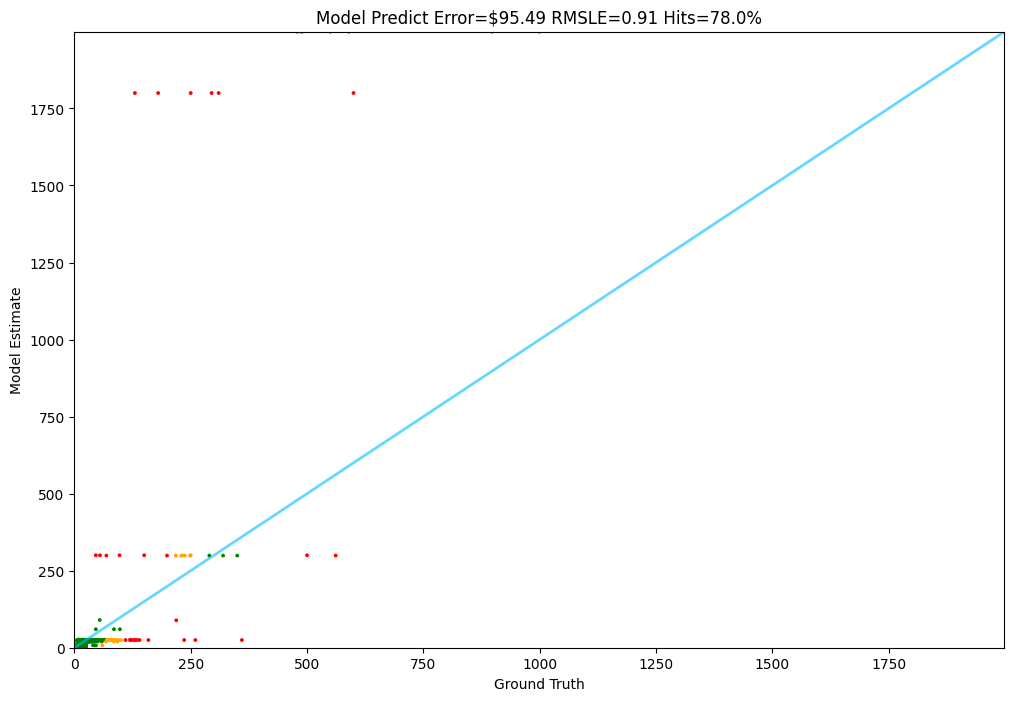

In [7]:
predictor = open_source_pricer_predictor(tokenizer, base_model)
Tester.test(predictor, test)

## Fine-tuining Llama Model

In [8]:
# Run name for saving the model in the hub

PROJECT_NAME = "pricer"
RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

In [5]:
# Hyperparameters for QLoRA

LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

# Hyperparameters for Training

EPOCHS = 1 # you can do more epochs if you wish, but only 1 is needed - more is probably overkill
BATCH_SIZE = 4 # on an A100 box this can go up to 16
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

# Admin config - note that SAVE_STEPS is how often it will upload to the hub
# I've changed this from 5000 to 2000 so that you get more frequent saves

STEPS = 50
SAVE_STEPS = 2000
LOG_TO_WANDB = True

In [9]:
HUB_MODEL_NAME

'hiennguyen231191/pricer-2025-07-09_13.41.12'

In [10]:
# Log in to Weights & Biases
os.environ["WANDB_API_KEY"] = os.getenv('WANDB_API_KEY', 'your-key-if-not-using-env')
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if LOG_TO_WANDB else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: Currently logged in as: pun2311 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
if LOG_TO_WANDB:
  wandb.init(project=PROJECT_NAME, name=RUN_NAME)

### Training Configuration

In [6]:
# Data collator. The trainer needs to teach the model to predict the token(s) after "Price is $".
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [11]:
# First, specify the configuration parameters for LoRA

lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training

train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)

# And now, the Supervised Fine Tuning Trainer will carry out the fine-tuning
# Given these 2 sets of configuration parameters
# The latest version of trl is showing a warning about labels - please ignore this warning
# But let me know if you don't see good training results (loss coming down).

fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train,
    peft_config=lora_parameters,
    args=train_parameters,
    data_collator=collator
  )

average_tokens_across_devices is set to True but it is invalid when world size is1. Turn it to False automatically.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [13]:
# Fine-tune!
fine_tuning.train()

# Push our fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


Step,Training Loss
50,1.847800
100,1.369600
150,1.370600
200,1.378900
250,1.376600
300,1.363900
350,1.363100
400,1.357700
450,1.340800
500,1.398800


wandb: Adding directory to artifact (./pricer-2025-07-07_12.42.08/checkpoint-2000)... Done. 0.3s
wandb: Adding directory to artifact (./pricer-2025-07-07_12.42.08/checkpoint-4000)... Done. 0.3s
wandb: Adding directory to artifact (./pricer-2025-07-07_12.42.08/checkpoint-6000)... Done. 0.3s
wandb: Adding directory to artifact (./pricer-2025-07-07_12.42.08/checkpoint-6250)... Done. 0.3s
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


README.md:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved to the hub: pricer-2025-07-07_12.42.08


### Testing

In [9]:
TEST_RUN_NAME = "2025-07-07_12.42.08"
TEST_PROJECT_RUN_NAME = f"{PROJECT_NAME}-{TEST_RUN_NAME}"
FINETUNED_MODEL = f"{HF_USER}/{TEST_PROJECT_RUN_NAME}"
REVISION = None

In [10]:
# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Memory footprint: 5700.6 MB


In [11]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

1: Guess: $25.00 Truth: $21.99 Error: $3.01 SLE: 0.02 Item: The Petting Zoo Bald Eagle Stuffed Anima...
2: Guess: $40.00 Truth: $99.99 Error: $59.99 SLE: 0.81 Item: Black Tilting Wall Mount Bracket for Viz...
3: Guess: $60.00 Truth: $199.00 Error: $139.00 SLE: 1.41 Item: Xantech Ensemble Universal IR Kit EN85K
...
4: Guess: $15.00 Truth: $15.99 Error: $0.99 SLE: 0.00 Item: Teenager Birthday Party Decoration 13th ...
5: Guess: $220.00 Truth: $229.99 Error: $9.99 SLE: 0.00 Item: Kodak PIXPRO Astro Zoom AZ421 16MP Digit...
6: Guess: $25.00 Truth: $24.44 Error: $0.56 SLE: 0.00 Item: Blessing Alto Saxophone Case
Blessing Tr...
7: Guess: $7.00 Truth: $9.99 Error: $2.99 SLE: 0.10 Item: 2PCS Household Basics Battery Chargers f...
8: Guess: $19.00 Truth: $16.99 Error: $2.01 SLE: 0.01 Item: SpyShop Oversize Water Bubble Ball Toy G...
9: Guess: $25.00 Truth: $75.50 Error: $50.50 SLE: 1.16 Item: Funko POP Movies Breakfast Club - Richar...
10: Guess: $950.00 Truth: $999.00 Error: $49.00 SLE: 0.00 I

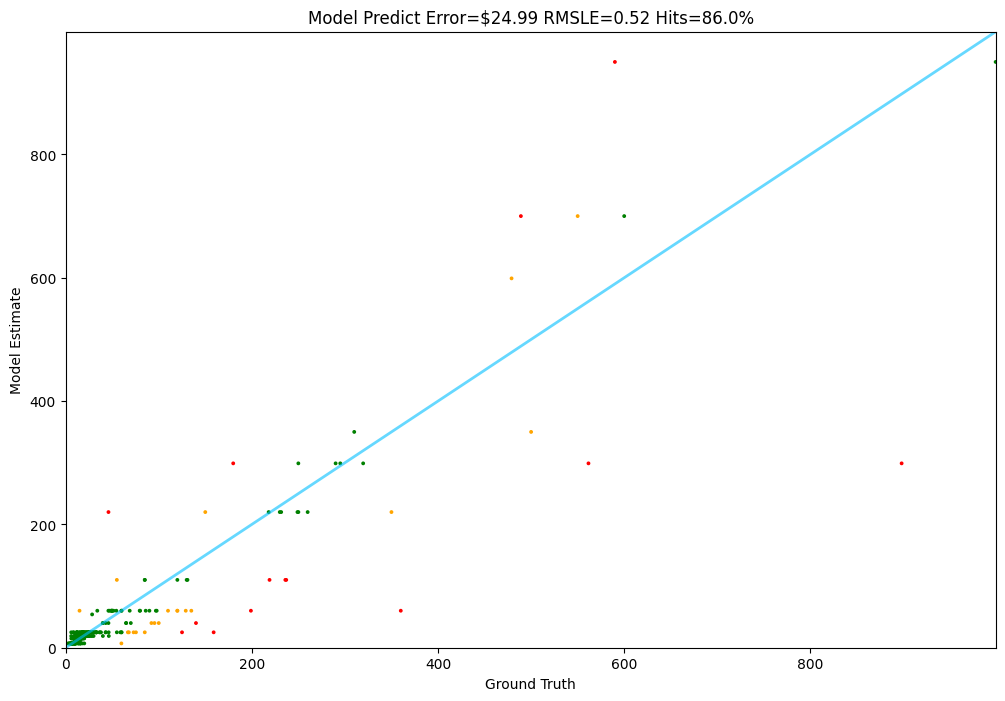

In [12]:
predictor = open_source_pricer_predictor(tokenizer, fine_tuned_model)
Tester.test(predictor, test)